In [11]:
#Get all of the subjects from the two groups
import numpy as np
import csv
from cmlreaders import CMLReader, get_data_index
df = get_data_index("r1")
tbi_subs = []
match_subs = []
match2_subs = []
with open('/home1/richad/TBI_Paper_Analysis/tbi3.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for rows in reader:  
        tbi_subs.append(rows[2])
    
with open('/home1/richad/TBI_Paper_Analysis/best_matches3.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for rows in reader:  
        match_subs.append(rows[2])    
        match2_subs.append(rows[2]) 
        
with open('/home1/richad/TBI_Paper_Analysis/second_best_matches3.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for rows in reader:      
        match2_subs.append(rows[2]) 
with open('/home1/richad/TBI_Paper_Analysis/third_best_matches3.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for rows in reader:      
        match2_subs.append(rows[2]) 
        
all_subs = tbi_subs+match2_subs

### Power

In [12]:
#Calculating spectral powers
def compPowers(s):
    from cmlreaders import CMLReader, get_data_index
    df = get_data_index("r1")
    import numpy as np
    import pickle as pk
    import os 
    
    sub = s
    sub_df=df[df['subject']==sub]
    exp = np.array(sub_df[(sub_df['experiment']=='FR1') | (sub_df['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    if os.path.exists('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_'+exp+'_powers_allFreqs.pkl')==False:
        try:
            #Get subject info
            sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
            mont = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['montage'])
            loc = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['localization'])

            recalled = []
            sess_pows = []

            for sess in sessions[:]:

                #For first session...
                reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                evs = reader.load('events')
                pairs=reader.load('pairs')
                #Only get encoding events
                word_evs = evs.query('type == "WORD"')  #could also have written word_evs = evs[evs['type']=='WORD']

                #Grab some EEG, and convert to MNE format
                buf = 1000  #to remove edge effects during wavelet convolution
                eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1600+buf,scheme=pairs)
                eeg_ptsa = eeg.to_ptsa()
                eeg_mne = eeg.to_mne()  #we might need this later

                from ptsa.data.filters import ButterworthFilter
                from ptsa.data.filters import MorletWaveletFilter
                import numpy as np

                sr = eeg_mne.info['sfreq']

                #Filter out line noise
                freq_range = [58., 62.]
                b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter()

                #Get spectral power
                myfreqs = np.logspace(np.log10(3), np.log10(170), 20)  #let's start with 3-170 Hz, 20 frequencies
                wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
                pow_wavelet = wf.filter()  #output is freqs, events, elecs, and time
                pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period
                pows = np.log10(pows)   #take log of powers

                #Reshape array to average into 100 ms bins
                samps = int(sr/10.)
                numwins = int(pows.shape[3]/samps)
                reshaped_arr = np.reshape(pows[:, :, :, :samps*numwins], (pows.shape[0], pows.shape[1], pows.shape[2], numwins, samps))
                avg_pows = np.mean(reshaped_arr, axis=4)

                from scipy.stats import zscore, ttest_ind
                z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
                sess_pows.append(z_pows)

                recalled.extend(list(word_evs['recalled'])) # we need to store this data across-sessions


            recalled = np.array(recalled)
            all_pows = np.concatenate(sess_pows, axis=1)

            #Compare remembered vs. not-remembered (final output in shape [freqs, elecs, time])
            tstats, pvals = ttest_ind(all_pows[:, recalled==1, :, :], all_pows[:, recalled==0, :, :], equal_var=False, axis=1)

            #First average powers in window of interest, which is 400ms to 1100ms
            win_pows = np.mean(all_pows[:, :, :, 4:12], 3)
            t_win, p_win = ttest_ind(win_pows[:, recalled==1, :], win_pows[:, recalled==0, :], equal_var=False, axis=1)
            #reshape twin to electrodes x frequencies
            t_win= np.transpose(t_win)
            p_win= np.transpose(p_win)
            #Construct dataframe to hold outputs
            import pandas as pd

            #get bad electrodes
            def exclude_pairs(s):
                from cmlreaders import CMLReader, get_data_index
                df = get_data_index("r1")
                #open electrode categories file and get all the bad electrodes
                try:
                    f = open('/data/eeg/'+str(s)+'/docs/electrode_categories.txt', 'r')
                except:
                    lines2='no electrode categories'
                    return(lines2)
                lines = f.readlines()
                f.close()
                lines1 = [i.replace('\n', '') for i in lines]
                lines2 = [x for x in lines1 if (x != '')]
                return(lines2)
            badElecs = exclude_pairs(sub)

            pow_df = pd.DataFrame()

            for idx in range(len(pairs)):
                if 'stein.region' in pairs.keys():
                    mtl_locs = pairs['stein.region']
                else:
                    mtl_locs = np.empty(len(pairs)); mtl_locs[:] = np.nan

                if 'mni.region' in pairs.keys():
                    mni_locs = pairs['mni.region']
                else:
                    mni_locs = np.empty(len(pairs)); mni_locs[:] = np.nan

                p1=pairs['label'][idx][:pairs['label'][idx].index("-")]
                p2=pairs['label'][idx][pairs['label'][idx].index("-")+1:]

                if ((p1 in badElecs) | (p2 in badElecs)):
                    bad_elecs = 1
                else:
                    bad_elecs = 0

                pow_df = pow_df.append({'tstats': t_win[idx], 'pvals': p_win[idx],  
                                       'ind.region': pairs.iloc()[idx]['ind.region'], 'stein.region': mtl_locs[idx], 
                                        'mni.region': mni_locs[idx],
                                       'ind.x': pairs.iloc()[idx]['ind.x'], 'ind.y': pairs.iloc()[idx]['ind.y'], 
                                       'ind.z': pairs.iloc()[idx]['ind.z'], 'avg.x': pairs.iloc()[idx]['avg.x'], 
                                        'avg.y': pairs.iloc()[idx]['avg.y'], 'avg.z': pairs.iloc()[idx]['avg.z'], 
                                        'subject':sub, 'experiment': exp, 'localization': loc, 'bp_idx':int(idx),
                                        'montage': mont, 'bad_elecs': bad_elecs, 'label': pairs.iloc()[idx]['label']}, ignore_index=True)


            pow_df.to_pickle('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_'+exp+'_powers_allFreqs.pkl')
        except Exception as e: 
            print(e)
            np.save('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_bad.npy',sub)
            return
    else:
        return
    return
#for s in tbi_subs:
#    compPowers(s)
    

/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipyker

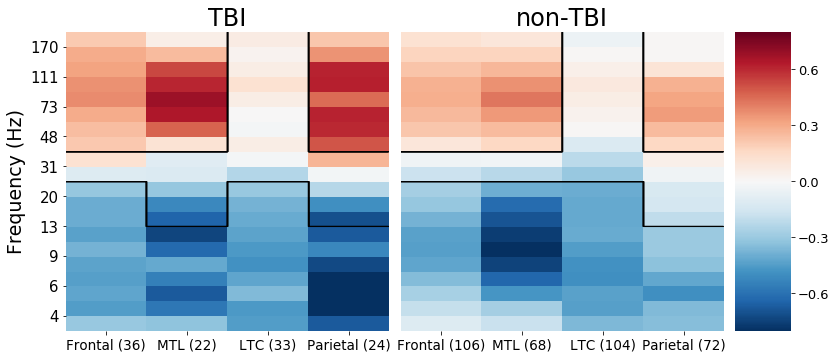

In [19]:
#Analyzing spectral powers
import pickle as pk
import numpy as np
#Set up dictionary for SME t-values for each of 4 regions
tbi_subs_t = {}
tbi_subs_t['Frontal'] = []; tbi_subs_t['MTL'] = []; tbi_subs_t['LTC'] = []; tbi_subs_t['Parietal'] = []; 
#load data
for s in tbi_subs:
    sub=s
    sub_info =df[df['subject']==sub]
    exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    try:
        pow_df = pk.load(open('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+str(sub)+'_'+str(exp)+'_powers_allFreqs.pkl', 'rb'))
    except:
        print(sub+' did not work')
        continue
    
    #Remove bad electrodes from data
    removeElecs=np.where(pow_df['bad_elecs']==1)[0]
    pow_df=pow_df.drop(index=removeElecs)
    pow_df=pow_df.reset_index()
    
    #find indeces of electrodes in regions of interest
    front_filt = pow_df['ind.region'].astype(str).str.contains('frontal') | pow_df['ind.region'].astype(str).str.contains('parsopercularis') | pow_df['ind.region'].astype(str).str.contains('parsorbitalis') | pow_df['ind.region'].astype(str).str.contains('parstriangularis')
    temp_filt = (pow_df['ind.region'].astype(str).str.contains('temporal') | pow_df['ind.region'].astype(str).str.contains('bankssts'))
    mtl_filt = pow_df['stein.region'].astype(str).str.contains('CA1') | pow_df['stein.region'].astype(str).str.contains('DG') | pow_df['ind.region'].astype(str).str.contains('parahippocampal') | pow_df['ind.region'].astype(str).str.contains('entorhinal') | pow_df['stein.region'].astype(str).str.contains('PRC') | pow_df['stein.region'].astype(str).str.contains('EC')           
    par_filt = pow_df['ind.region'].astype(str).str.contains('parietal')
    #average the tstat values for all electrodes in each ROI
    tbi_subs_t['Frontal'].append(np.nanmean(tuple(pow_df[front_filt]['tstats']),axis=0))
    tbi_subs_t['LTC'].append(np.nanmean(tuple(pow_df[temp_filt]['tstats']),axis=0))
    tbi_subs_t['MTL'].append(np.nanmean(tuple(pow_df[mtl_filt]['tstats']),axis=0))
    tbi_subs_t['Parietal'].append(np.nanmean(tuple(pow_df[par_filt]['tstats']),axis=0))    
    
#same procedure for match group
match_subs_t = {}

match_subs_t['Frontal'] = []; match_subs_t['MTL'] = []; match_subs_t['LTC'] = []; match_subs_t['Parietal'] = [];
for s in match2_subs:
    sub=s
    sub_info =df[df['subject']==sub]
    exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    try:
        pow_df = pk.load(open('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+str(sub)+'_'+str(exp)+'_powers_allFreqs.pkl', 'rb'))
    
    except:
        print(sub+' did not work')
        continue
        
    #Remove bad electrodes from data
    removeElecs=np.where(pow_df['bad_elecs']==1)[0]
    pow_df=pow_df.drop(index=removeElecs)
    pow_df=pow_df.reset_index()
    
    front_filt = pow_df['ind.region'].astype(str).str.contains('frontal') | pow_df['ind.region'].astype(str).str.contains('parsopercularis') | pow_df['ind.region'].astype(str).str.contains('parsorbitalis') | pow_df['ind.region'].astype(str).str.contains('parstriangularis')
    temp_filt = (pow_df['ind.region'].astype(str).str.contains('temporal') | pow_df['ind.region'].astype(str).str.contains('bankssts'))
    mtl_filt = pow_df['stein.region'].astype(str).str.contains('CA1') | pow_df['stein.region'].astype(str).str.contains('DG') | pow_df['ind.region'].astype(str).str.contains('parahippocampal') | pow_df['ind.region'].astype(str).str.contains('entorhinal') | pow_df['stein.region'].astype(str).str.contains('PRC') | pow_df['stein.region'].astype(str).str.contains('EC')           
    par_filt = pow_df['ind.region'].astype(str).str.contains('parietal')
    
    match_subs_t['Frontal'].append(np.nanmean(tuple(pow_df[front_filt]['tstats']),axis=0))
    match_subs_t['LTC'].append(np.nanmean(tuple(pow_df[temp_filt]['tstats']),axis=0))
    match_subs_t['MTL'].append(np.nanmean(tuple(pow_df[mtl_filt]['tstats']),axis=0))
    match_subs_t['Parietal'].append(np.nanmean(tuple(pow_df[par_filt]['tstats']),axis=0))
#turn dictionaries to dataframes
import pandas as pd
tbi_df = pd.DataFrame(tbi_subs_t)
match_df = pd.DataFrame(match_subs_t)

tbi_subs_df = tbi_df.rename(columns = {0:'Frontal (36)',1:'MTL (22)',2:'LTC (33)',3:'Parietal (24)'})
match_subs_df = match_df.rename(columns = {0:'Frontal (106)',1:'MTL (68)',2:'LTC (104)',3:'Parietal (72)'})

#Organize SME and plot as well as p vlaues for each freq/roi
import pandas as pd
from scipy import stats
import mne
from mne.stats import bonferroni_correction
myfreqs = np.logspace(np.log10(3), np.log10(170), 20)
#find freq bands of each freq
band = []
for f in myfreqs:
    if (f>=3.0) & (f<8.0):
        band.append('theta')
    elif (f>=8.0) & (f<15.0):
        band.append('alpha')
    elif (f>=15.0) & (f<31.0):
        band.append('beta')
    elif (f>=45.0) & (f<171.0):
        band.append('gamma')
band=np.array(band)
band_strings = ['theta','alpha','beta','gamma']

#tbi_subs_t_df = pd.DataFrame(tbi_subs_t)
cols = tbi_subs_df.columns.tolist()
tbi_dict = {}
tbi_avg = {}; tbi_avg['theta']=[];tbi_avg['alpha']=[];tbi_avg['beta']=[];tbi_avg['gamma']=[]
match_dict = {}
match_avg = {}; match_avg['theta']=[];match_avg['alpha']=[];match_avg['beta']=[];match_avg['gamma']=[]

ind_avg = {}; ind_avg['theta']=[];ind_avg['alpha']=[];ind_avg['beta']=[];ind_avg['gamma']=[]

for c in cols: #loop over regions
    tbi_ts = tbi_subs_df[c].tolist()
    tbi_ts = [x for x in tbi_ts if str(x) != 'nan']
    tbi_ts_df = pd.DataFrame(tbi_ts)
    match_ts = match_subs_df[c].tolist()
    match_ts = [x for x in match_ts if str(x) != 'nan']
    match_ts_df = pd.DataFrame(match_ts)

    for b in band_strings: #loop over frequency bands
        #average all tstats for frequencies in the same band, and do a one sample t-test comparing the results to zero in each region/freq-band
        tbi_avg[b].append(stats.ttest_1samp(tbi_ts_df[np.where(band==b)[0]].mean(axis=1),0)[1])
        match_avg[b].append(stats.ttest_1samp(match_ts_df[np.where(band==b)[0]].mean(axis=1),0)[1])
        #t-test comparing tbi to non-tbi power sme t-stats in each region/freq-band
        ind_avg[b].append(stats.ttest_ind(tbi_ts_df[np.where(band==b)[0]].mean(axis=1),match_ts_df[np.where(band==b)[0]].mean(axis=1),equal_var=False,nan_policy='omit')[1])

    tbi_dict[c]=np.nanmean(tbi_ts,axis=0)
    match_dict[c]=np.nanmean(match_ts,axis=0)
    #tbi_dict[c]=np.median(tbi_ts,axis=0)
    #match_dict[c]=np.median(match_ts,axis=0)
    
tbi_df = pd.DataFrame(tbi_dict)
tbi_df = tbi_df.rename(columns = {'Frontal':'Frontal (36)','MTL':'MTL (22)','LTC':'LTC (33)','Parietal':'Parietal (24)'})
tbi_pvalues = pd.DataFrame(tbi_avg).T.rename(columns={0:'Frontal (36)',1:'MTL (22)',2:'LTC (33)',3:'Parietal (24)'})
match_df = pd.DataFrame(match_dict)
match_df = match_df.rename(columns = {'Frontal':'Frontal (106)','MTL':'MTL (68)','LTC':'LTC (104)','Parietal':'Parietal (72)'})
match_pvalues = pd.DataFrame(match_avg).T.rename(columns={0:'Frontal (106)',1:'MTL (68)',2:'LTC (104)',3:'Parietal (72)'})

ind_pvalues = pd.DataFrame(ind_avg).T.rename(columns={0:'Frontal',1:'MTL',2:'LTC',3:'Parietal'})

tbi_sigmatrix = np.zeros([20,4]).astype(bool)
tbi_sigmatrix[0:4,0]=1 ; tbi_sigmatrix[4:7,0]=1; tbi_sigmatrix[7:10,0]=1; tbi_sigmatrix[12:20,0]=1
tbi_sigmatrix[0:4,1]=1; tbi_sigmatrix[4:7,1]=1; tbi_sigmatrix[7:10,1]=0; tbi_sigmatrix[12:20,1]=1
tbi_sigmatrix[0:4,2]=1 ; tbi_sigmatrix[4:7,2]=1; tbi_sigmatrix[7:10,2]=1; tbi_sigmatrix[12:20,2]=0
tbi_sigmatrix[0:4,3]=1 ; tbi_sigmatrix[4:7,3]=1; tbi_sigmatrix[7:10,3]=0; tbi_sigmatrix[12:20,3]=1
tbi_sigmatrix=np.flip(tbi_sigmatrix,0)

match_sigmatrix = np.zeros([20,4]).astype(bool)
match_sigmatrix[0:4,0]=1 ; match_sigmatrix[4:7,0]=1; match_sigmatrix[7:10,0]=1; match_sigmatrix[12:20,0]=1
match_sigmatrix[0:4,1]=1 ; match_sigmatrix[4:7,1]=1; match_sigmatrix[7:10,1]=1; match_sigmatrix[12:20,1]=1
match_sigmatrix[0:4,2]=1 ; match_sigmatrix[4:7,2]=1; match_sigmatrix[7:10,2]=1; match_sigmatrix[12:20,2]=0
match_sigmatrix[0:4,3]=1 ; match_sigmatrix[4:7,3]=1; match_sigmatrix[7:10,3]=0; match_sigmatrix[12:20,3]=1
match_sigmatrix=np.flip(match_sigmatrix,0)
#round frequencies to make axes labels nicer
for x in range(20):
    tbi_df = tbi_df.rename(index={x:str(int(round(myfreqs[x])))})
for x in range(20):
    match_df = match_df.rename(index={x:str(int(round(myfreqs[x])))})

#Plot heatmaps Power SME
%matplotlib inline
from pylab import *
import seaborn as sns

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(13,5.5))

#fig, axs = plt.subplots(1,3, figsizes=, gridspec_kw=dict())

gs=GridSpec(1,11)
ax5=fig.add_subplot(gs[0,10]) # First row, third column

ax1=fig.add_subplot(gs[0,0:5]) # First row, first column
title('TBI',size=24)
sns.heatmap(tbi_df,cmap = 'RdBu_r',yticklabels=False,cbar=False,vmin=-.8,vmax=.8)
#Function for adding lines to denote significant regions
def plot_pixel_contour(ax, sigmatrix):
        f = lambda x,y: sigmatrix[int(y),int(x)]
        g = np.vectorize(f)

        x = np.linspace(0, sigmatrix.shape[1], sigmatrix.shape[1]*100)
        y = np.linspace(0, sigmatrix.shape[0], sigmatrix.shape[0]*100)
        X, Y= np.meshgrid(x[:-1],y[:-1])
        Z = g(X[:-1],Y[:-1])
        ax.contour(X[:-1],Y[:-1],Z[::-1],colors='k',linewidths=[1],origin='upper')
        return
plot_pixel_contour(ax1,tbi_sigmatrix)
ax1.invert_yaxis()
indeces = [1,3,5,7,9,11,13,15,17,19]
ax1.set_yticks(indeces)
ax1.set_yticklabels(np.array(tbi_df.index)[indeces],fontsize=15)
ylabel('Frequency (Hz)',fontsize=19)
xticks(fontsize=13.5)

ax2=fig.add_subplot(gs[0,5:10]) # First row, second column
title('non-TBI',size=24)
sns.heatmap(match_df,cmap = 'RdBu_r',cbar=True,yticklabels=False,cbar_ax=ax5, vmin=-.8,vmax=.8)
plot_pixel_contour(ax2,match_sigmatrix)
ax2.invert_yaxis()
labels = [item.get_text() for item in ax5.get_yticklabels()]
ax5.set_yticklabels(labels,fontsize=13)
xticks(fontsize=13.5)

fig.savefig("powerSme_lines.pdf",dpi=300, bbox_inches = "tight")

In [20]:
#Statistical Analysis:
#Averaged the sme values at each region/freq-band  and did a 1-sample t-test comparing the distribution to 0. These are the resulting p-values
tbi_pvalues

,Frontal (36),MTL (22),LTC (33),Parietal (24)
theta,0.002975,0.022656,0.000985,0.000384
alpha,0.004214,0.005938,0.014816,0.011282
beta,0.003169,0.144489,0.030832,0.220594
gamma,0.001247,0.011412,0.662809,0.004176


In [21]:
#I then used benjamini hichberg to correct for multiple comparisons. True signifies significance (rejecting the null hypothesis)
from statsmodels.stats.multitest import multipletests
reject , corP, alpha1, alpha2 = multipletests(np.concatenate(np.array(tbi_pvalues).T),alpha = 0.05, method = 'fdr_bh')
reject_df = {}
reject_df['Frontal'] = reject[0:4]; reject_df['MTL'] = reject[4:8];reject_df['Temporal'] = reject[8:12];reject_df['Parietal'] = reject[12:16];
reject_df = pd.DataFrame(reject_df)
reject_df = reject_df.rename(index = {0:'theta',1:'alpha',2:'beta',3:'gamma'})
reject_df

,Frontal,MTL,Temporal,Parietal
theta,True,True,True,True
alpha,True,True,True,True
beta,True,False,True,False
gamma,True,True,False,True


In [22]:
match_pvalues

,Frontal (106),MTL (68),LTC (104),Parietal (72)
theta,2.163846e-04,3.412037e-05,1.099170e-09,0.000227
alpha,1.386433e-08,1.074158e-08,8.205195e-10,0.034385
beta,4.847041e-05,4.169599e-04,1.976786e-08,0.320642
gamma,4.147215e-04,3.478439e-03,7.507613e-01,0.005793


In [23]:
from statsmodels.stats.multitest import multipletests
reject , corP, alpha1, alpha2 = multipletests(np.concatenate(np.array(match_pvalues).T),alpha = 0.05, method = 'fdr_bh')
reject_df = {}
reject_df['Frontal'] = reject[0:4]; reject_df['MTL'] = reject[4:8];reject_df['Temporal'] = reject[8:12];reject_df['Parietal'] = reject[12:16];
reject_df = pd.DataFrame(reject_df)
reject_df = reject_df.rename(index = {0:'theta',1:'alpha',2:'beta',3:'gamma'})
reject_df

,Frontal,MTL,Temporal,Parietal
theta,True,True,True,True
alpha,True,True,True,True
beta,True,True,True,False
gamma,True,True,False,True


In [24]:
#I also did an independent t-test between the groups at each region/freq-band. These are the p-values
ind_pvalues

,Frontal,MTL,LTC,Parietal
theta,0.338532,0.843810,0.941181,0.072824
alpha,0.922853,0.724575,0.954260,0.165769
beta,0.856321,0.684811,0.672573,0.506963
gamma,0.374010,0.347897,0.593415,0.098618


In [25]:
#There were no significant differences
from statsmodels.stats.multitest import multipletests
reject , corP, alpha1, alpha2 = multipletests(np.concatenate(np.array(ind_pvalues).T),alpha = 0.05, method = 'fdr_bh')
reject_df = {}
reject_df['Frontal'] = reject[0:4]; reject_df['MTL'] = reject[4:8];reject_df['Temporal'] = reject[8:12];reject_df['Parietal'] = reject[12:16];
reject_df = pd.DataFrame(reject_df)
reject_df = reject_df.rename(index = {0:'theta',1:'alpha',2:'beta',3:'gamma'})
reject_df

,Frontal,MTL,Temporal,Parietal
theta,False,False,False,False
alpha,False,False,False,False
beta,False,False,False,False
gamma,False,False,False,False


### Connectivity

In [ ]:
#Calculating Connectivity
def compConnectNoMne(s):
    import os
    #Get Subject Info 
    import numpy as np
    import pandas as pd
    from cmlreaders import CMLReader, get_data_index
    import time
    start=time.time()
    df = get_data_index("r1")
    sub=s
    if os.path.exists('/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/'+str(sub)+'_ConnectivityFull_noMne.npy')==False:
        sub_info =df[df['subject']==sub]
        exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
        if len(exp)>0:
            if sum(exp=='FR1')>sum(exp=='catFR1'):
                exp='FR1'
            else:
                exp='catFR1'
            #Get subject info
        sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
        mont = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['montage'])
        loc = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['localization'])

        sess_phase = []
        recalled = []
        #loop over sessions
        for sess in sessions:
            reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
            pairs= reader.load('pairs')  #loading all bipolar pairs
            evs = reader.load('events')

            #Only get encoding events
            word_evs = evs.query('type == "WORD"')  
            
            buf = 1000  #to remove edge effects during wavelet convolution
            eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1600+buf, scheme=pairs)
            eeg_ptsa = eeg.to_ptsa()
            from ptsa.data.filters import ButterworthFilter
            from ptsa.data.filters import MorletWaveletFilter
            sr = eeg.samplerate
            #Filter out line noise
            freq_range = [58., 62.]
            b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
            eeg_filtered = b_filter.filter()
            #Get spectral PHASE
            myfreqs = np.array([4, 5, 6, 7, 8])   #focus on theta frequencies
            wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='phase')
            phase_wavelet = wf.filter()   #output is freqs, events, elecs, and time
            phase = phase_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period

            sess_phase.append(phase)
            recalled.extend(list(word_evs['recalled'])) 

        all_phase = np.concatenate(sess_phase, axis=1)
        recalled=np.array(recalled)

        myfreqs = np.array([4,5,6,7,8])

        from itertools import combinations
        import pycircstat as circ

        possible_pairs = combinations(range(0, all_phase.shape[2]), 2)
        pp = np.array(list(possible_pairs))

        sr_ms = sr/1000
        time1=int(sr_ms*400)
        time2=int(sr_ms*1100)

        con_mat = np.empty((all_phase.shape[2], all_phase.shape[2],np.shape(myfreqs)[0])); con_mat[:] = np.nan
        diff_mat = np.empty((all_phase.shape[2], all_phase.shape[2],all_phase.shape[1],np.shape(myfreqs)[0])); diff_mat[:] = np.nan
        for i in range(np.shape(myfreqs)[0]):
            for p in pp: 

                #Get the phase diffs
                diffs = circ.cdiff(all_phase[i, :, p[0], time1:time2], all_phase[i, :, p[1], time1:time2])

                #Mean in the time window
                diffs_avg = circ.mean(diffs, axis=1)

                diff_mat[p[0],p[1],:,i]= diffs_avg

                #Get PLV
                plv = circ.resultant_vector_length(diffs_avg[recalled==1]) - circ.resultant_vector_length(diffs_avg[recalled==0])

                con_mat[p[0], p[1],i] = plv

        #average over frequency
        con_mat_avg=np.nanmean(con_mat,axis=2)

        first_part=time.time()-start

        nRandomizations = 500
        #null_mat = np.empty((nRandomizations,all_phase.shape[2], all_phase.shape[2],len(myfreqs))); null_mat[:] = np.nan
        null_mat_full=[] #will naturall fill up in the right dimensions
        #null_mat_full = np.empty((nRandomizations,all_phase.shape[2], all_phase.shape[2],len(myfreqs))); null_mat[:] = np.nan
        num_rec = np.sum(recalled)  #how many remembered
        idx_vec = np.arange(len(recalled))  #vector of indices
        for k in range(nRandomizations):
            null_mat = np.empty((all_phase.shape[2], all_phase.shape[2],len(myfreqs))); null_mat[:] = np.nan
            #np.save('/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/'+str(s[0])+'/'+str(s[0])+str(k)+'.npy',k)
            np.random.shuffle(idx_vec)
            shuffled_idx = np.copy(idx_vec)
            null_rec = idx_vec[:num_rec]   #creating null groups of 'rec' and 'not-rec'
            null_nrec = idx_vec[num_rec:]

            for i in range(np.shape(myfreqs)[0]):
                for p in pp:
                    plv = circ.resultant_vector_length(diff_mat[p[0],p[1],null_rec,i])-circ.resultant_vector_length(diff_mat[p[0],p[1],null_nrec,i])

                    null_mat[p[0], p[1],i] = plv
            null_mat_avg=np.nanmean(null_mat,axis=2)

            null_mat_full.append(null_mat_avg)
            #print('done '+str(k))

        dstats = np.concatenate(([con_mat_avg],null_mat_full),axis=0)
        fullruntime= time.time()-start
        np.save(str(sub)+'_ConnectivityFull_noMne.npy',dstats)
    else:
        print('This subject has already been completed')
    return

In [27]:
#Get all possible region labels from all subjects
import numpy as np
import pandas as pd
import pickle as pk
avg_region_subs = []
all_region_labels = []
#stein_region_labels = []
for s in all_subs:
    sub = s
    sub_info =df[df['subject']==sub]
    exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    try:
        #Get subject electrode info
        sub_df = pk.load(open('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_'+exp+'_'+'powers_allFreqs.pkl', 'rb'))
        if len(set(list(sub_df['ind.region'])))==1:
            print(sub+' ind.region only None labels')
            avg_region_subs.append(sub)
        #Load the data
        mat = np.load('/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/'+sub+'_ConnectivityFull_noMne.npy')
           
    except:
        continue
    if sub in avg_region_subs: #for R1027J
        all_region_labels.extend(sub_df['avg.region'].astype(str))
    else:
        all_region_labels.extend(sub_df['ind.region'].astype(str))
        all_region_labels.extend(sub_df['stein.region'].astype(str))
#combine hippocampus regions
#L_hippo_regions = ['Left CA1', 'Left CA2','Left CA3','Left DG','Left Sub']
#R_hippo_regions = ['Right CA1', 'Right CA2','Right CA3','Right DG','Right Sub']
#all_region_labels = ['Left hippocampus' if (x in L_hippo_regions)==True else x for x in all_region_labels]
#all_region_labels = ['Right hippocampus' if (x in R_hippo_regions)==True else x for x in all_region_labels]
#consolidate
all_region_labels = np.unique(all_region_labels)
all_region_labels = all_region_labels[all_region_labels!='nan']
all_region_labels = all_region_labels[all_region_labels!='None']
all_region_labels = all_region_labels[all_region_labels!='unknown']   
     

R1027J ind.region only None labels


In [28]:
# Get the Z-score for each unique region pair for each TBI subject

#add right and left to the roi labels
import itertools
#TBI_sub_IDs = [s[0] for s in TBI_subs_FR]
TBI_sub_IDs = tbi_subs
nShuffles = 500
wb_labels = []
wb_labels.extend(['L '+s for s in all_region_labels if ('Right' in s)==False])
wb_labels.extend(['R '+s for s in all_region_labels if ('Left' in s)==False])

tbi_matrix = np.empty([len(TBI_sub_IDs), len(wb_labels), len(wb_labels),nShuffles+1])
tbi_matrix[:] = np.nan
z_tbi_matrix = np.empty([len(TBI_sub_IDs), len(wb_labels), len(wb_labels)])
z_tbi_matrix[:] = np.nan

region_pairs = list(itertools.combinations(range(len(wb_labels)), 2))
#get the data
good_subs_t = []
bad_subs_t = []
L_hippo_regions = ['Left CA1', 'Left CA2','Left CA3','Left DG','Left Sub']
R_hippo_regions = ['Right CA1', 'Right CA2','Right CA3','Right DG','Right Sub']

from cmlreaders import CMLReader, get_data_index
df = get_data_index("r1")
for sidx, s in enumerate(tbi_subs):
    sub=s
    sub_info =df[df['subject']==sub]
    exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    
    try:
        #Get subject electrode info
        sub_df = pk.load(open('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_'+exp+'_'+'powers_allFreqs.pkl', 'rb'))
        #ind_regions = np.array(sub_df['ind.region'])
        #stein_regions = np.array(sub_df['stein.region'])
        #stein_regions = ['Left hippocampus' if (x in L_hippo_regions)==True else x for x in stein_regions]
        #stein_regions = ['Right hippocampus' if (x in R_hippo_regions)==True else x for x in stein_regions]
        #stein_regions=np.array(stein_regions)
        #Load the data
        mat = np.load('/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/'+sub+'_ConnectivityFull_noMne.npy')
        good_subs_t.append(sub)
    except:
        print(str(s)+' not load')
        bad_subs_t.append(sub)
        continue
   
    #Get electrode pairs
    for p in region_pairs:
        region_A = wb_labels[p[0]]
        region_B = wb_labels[p[1]]
        if sub=='R1027J': #because R1027J doesnt have ind.region
            region_str = 'avg.region'
            loc_str = 'avg.x'
        else:
            region_str = 'ind.region'
            loc_str = 'ind.x'
            
        if region_A[0]=='L':
            elecs_A = np.where(((sub_df[region_str].astype(str).str.contains(region_A[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_A[2:]))) & (sub_df[loc_str].astype(float)<0))[0]
            #elecs_A = np.where(((ind_regions==region_A[2:]) | (stein_regions == region_A[2:])) & (sub_df['ind.x'].astype(float)<0))[0]
        else:
            elecs_A = np.where(((sub_df[region_str].astype(str).str.contains(region_A[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_A[2:]))) & (sub_df[loc_str].astype(float)>0))[0] 
            #elecs_A = np.where(((ind_regions==region_A[2:]) | (stein_regions == region_A[2:])) & (sub_df['ind.x'].astype(float)>0))[0]
        if region_B[0]=='L':
            elecs_B = np.where(((sub_df[region_str].astype(str).str.contains(region_B[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_B[2:]))) & (sub_df[loc_str].astype(float)<0))[0]
            #elecs_B = np.where(((ind_regions==region_B[2:]) | (stein_regions == region_B[2:])) & (sub_df['ind.x'].astype(float)<0))[0]
        else:
            elecs_B = np.where(((sub_df[region_str].astype(str).str.contains(region_B[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_B[2:]))) & (sub_df[loc_str].astype(float)>0))[0]
            #elecs_B = np.where(((ind_regions==region_B[2:]) | (stein_regions == region_B[2:])) & (sub_df['ind.x'].astype(float)>0))[0]
        if (len(elecs_A)==0) or (len(elecs_B)==0):
            continue
        
        cons = []
        for i in elecs_A:
            for j in elecs_B:
                if (np.isnan(mat[0, i, j])):
                    cons.append(mat[:, j, i])
                else:
                    cons.append(mat[:, i, j])
        if len(cons)==0:
            continue
        cons = np.array(cons)
        cons_avg = np.nanmean(cons, 0)
        z = (cons_avg[0]-np.mean(cons_avg[1:]))/np.std(cons_avg[1:])
        
        tbi_matrix[sidx, p[0], p[1],:] = cons_avg
        z_tbi_matrix[sidx, p[0], p[1]] = z
    print(sub)
#tbi_sub_avg=np.nanmean(tbi_matrix,axis=0)
#z_tbi = (tbi_sub_avg[:,:,0]-np.nanmean(tbi_sub_avg[:,:,1:]))/np.nanstd(tbi_sub_avg[:,:,1:]) 

#z_tbi_mat =  np.empty([len(wb_labels), len(wb_labels)])
#z_tbi_mat[:] = np.nan

#for p in region_pairs:
#    z_tbi_mat[p[0],p[1]] = (tbi_sub_avg[p[0],p[1],0]-np.nanmean(tbi_sub_avg[p[0],p[1],1:]))/np.nanstd(tbi_sub_avg[p[0],p[1],1:])
# Get the Z-score for each unique region pair for each TBI subject

#add right and left to the roi labels
import itertools
#match_sub_IDs = [s[0] for s in match_subs_FR]
match_sub_IDs = match2_subs
nShuffles = 500
wb_labels = []
wb_labels.extend(['L '+s for s in all_region_labels if ('Right' in s)==False])
wb_labels.extend(['R '+s for s in all_region_labels if ('Left' in s)==False])

match_matrix = np.empty([len(match_sub_IDs), len(wb_labels), len(wb_labels),nShuffles+1])
match_matrix[:] = np.nan
z_match_matrix = np.empty([len(match_sub_IDs), len(wb_labels), len(wb_labels)])
z_match_matrix[:] = np.nan

region_pairs = list(itertools.combinations(range(len(wb_labels)), 2))
#get the data
good_subs_t = []
bad_subs_t = []
L_hippo_regions = ['Left CA1', 'Left CA2','Left CA3','Left DG','Left Sub']
R_hippo_regions = ['Right CA1', 'Right CA2','Right CA3','Right DG','Right Sub']

from cmlreaders import CMLReader, get_data_index
df = get_data_index("r1")
for sidx, s in enumerate(match2_subs):
    sub=s
    sub_info =df[df['subject']==sub]
    exp = np.array(sub_info[(sub_info['experiment']=='FR1') | (sub_info['experiment']=='catFR1')]['experiment'])
    if len(exp)>0:
        if sum(exp=='FR1')>sum(exp=='catFR1'):
            exp='FR1'
        else:
            exp='catFR1'
    
    try:
        #Get subject electrode info
        sub_df = pk.load(open('/home1/richad/TBI_Paper_Analysis/Biomarkers/Power/all_freqs/'+sub+'_'+exp+'_'+'powers_allFreqs.pkl', 'rb'))
        #ind_regions = np.array(sub_df['ind.region'])
        #stein_regions = np.array(sub_df['stein.region'])
        #stein_regions = ['Left hippocampus' if (x in L_hippo_regions)==True else x for x in stein_regions]
        #stein_regions = ['Right hippocampus' if (x in R_hippo_regions)==True else x for x in stein_regions]
        #stein_regions=np.array(stein_regions)
        #Load the data
        mat = np.load('/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/'+sub+'_ConnectivityFull_noMne.npy')
        good_subs_t.append(sub)
    except:
        print(str(s)+' not load')
        bad_subs_t.append(sub)
        continue
   
    #Get electrode pairs
    for p in region_pairs:
        region_A = wb_labels[p[0]]
        region_B = wb_labels[p[1]]
        if sub=='R1027J': #because R1027J doesnt have ind.region
            region_str = 'avg.region'
            loc_str = 'avg.x'
        else:
            region_str = 'ind.region'
            loc_str = 'ind.x'
            
        if region_A[0]=='L':
            elecs_A = np.where(((sub_df[region_str].astype(str).str.contains(region_A[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_A[2:]))) & (sub_df[loc_str].astype(float)<0))[0]
            #elecs_A = np.where(((ind_regions==region_A[2:]) | (stein_regions == region_A[2:])) & (sub_df['ind.x'].astype(float)<0))[0]
        else:
            elecs_A = np.where(((sub_df[region_str].astype(str).str.contains(region_A[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_A[2:]))) & (sub_df[loc_str].astype(float)>0))[0] 
            #elecs_A = np.where(((ind_regions==region_A[2:]) | (stein_regions == region_A[2:])) & (sub_df['ind.x'].astype(float)>0))[0]
        if region_B[0]=='L':
            elecs_B = np.where(((sub_df[region_str].astype(str).str.contains(region_B[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_B[2:]))) & (sub_df[loc_str].astype(float)<0))[0]
            #elecs_B = np.where(((ind_regions==region_B[2:]) | (stein_regions == region_B[2:])) & (sub_df['ind.x'].astype(float)<0))[0]
        else:
            elecs_B = np.where(((sub_df[region_str].astype(str).str.contains(region_B[2:])) | (sub_df['stein.region'].astype(str).str.contains(region_B[2:]))) & (sub_df[loc_str].astype(float)>0))[0]
            #elecs_B = np.where(((ind_regions==region_B[2:]) | (stein_regions == region_B[2:])) & (sub_df['ind.x'].astype(float)>0))[0]
        if (len(elecs_A)==0) or (len(elecs_B)==0):
            continue
        
        cons = []
        for i in elecs_A:
            for j in elecs_B:
                if (np.isnan(mat[0, i, j])):
                    cons.append(mat[:, j, i])
                else:
                    cons.append(mat[:, i, j])
        if len(cons)==0:
            continue
        cons = np.array(cons)
        cons_avg = np.nanmean(cons, 0)
        z = (cons_avg[0]-np.mean(cons_avg[1:]))/np.std(cons_avg[1:])
        
        match_matrix[sidx, p[0], p[1],:] = cons_avg
        z_match_matrix[sidx, p[0], p[1]] = z
    print(sub)
#match_sub_avg=np.nanmean(match_matrix,axis=0)
#z_match = (match_sub_avg[:,:,0]-np.nanmean(match_sub_avg[:,:,1:]))/np.nanstd(match_sub_avg[:,:,1:]) 

#z_match_mat =  np.empty([len(wb_labels), len(wb_labels)])
#z_match_mat[:] = np.nan

#for p in region_pairs:
#    z_match_mat[p[0],p[1]] = (match_sub_avg[p[0],p[1],0]-np.nanmean(match_sub_avg[p[0],p[1],1:]))/np.nanstd(match_sub_avg[p[0],p[1],1:])

np.save("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/tbi_matrix.npy",tbi_matrix)
np.save("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/z_tbi_matrix.npy",z_tbi_matrix)
np.save("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/match_matrix.npy",match_matrix)
np.save("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/z_match_matrix.npy",z_match_matrix)


R1016M
R1021D
R1027J
R1041M
R1063C
R1102P


/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice


R1105E
R1130M
R1144E
R1156D
R1162N
R1164E
R1169P
R1195E
R1201P
R1212P
R1221P
R1227T
R1235E
R1317D
R1337E
R1339D
R1345D
R1374T
R1379E
R1413D
R1415T
R1421M
R1445E
R1450D
R1457T
R1465D
R1487T
R1488T
R1489E
R1491T
R1498D
R1039M
R1066P


/home1/richad/.conda/envs/new_environment/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: Mean of empty slice


R1135E
R1171M
R1128E
R1151E
R1239E
R1350D
R1045E
R1049J
R1033D
R1303E
R1100D
R1476J
R1192C
R1178P
R1145J
R1084T
R1089P
R1425D
R1275D
R1142N
R1198M
R1044J
R1155D
R1069M
R1153T
R1035M
R1075J
R1015J
R1104D
R1168T
R1003P
R1076D
R1120E
R1228M
R1187P
R1316T
R1388T
R1288P
R1277J
R1230J
R1200T
R1386T
R1378T
R1092J
R1260D
R1304N
R1366J
R1236J
R1484T
R1406M
R1342M
R1394E
R1318N
R1341T
R1427T
R1299T
R1338T
R1232N
R1057E
R1323T
R1279P
R1166D
R1056M
R1217T
R1196N
R1380D
R1190P
R1114C
R1245E
R1207J
R1229M
R1274T
R1397D
R1449T
R1306E
R1486J
R1438M
R1254E
R1409D
R1444D
R1147P
R1447M
R1396T
R1395M
R1315T
R1490T
R1467M
R1398J
R1493T
R1332M
R1460M
R1443D
R1347D
R1384J
R1243T
R1320D
R1403N
R1485J
R1251M
R1068J
R1377M
R1273D
R1401J
R1416T
R1391T
R1448T
R1266J
R1383J
R1331T


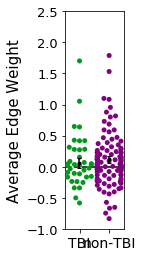

In [30]:
def scatterPlot(array1,title1,array2,title2):
    colors = [(0,.6,.1), (.5,0,.5)]
    connect_df = {}
    connect_df['value'] = np.concatenate([array1, array2])
    connect_df['sub']=np.concatenate([[str(title1)]*np.shape(array1)[0],[str(title2)]*np.shape(array2)[0]])
    import seaborn as sns
    %matplotlib inline
    from pylab import plot 
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    fig=plt.figure(figsize=(3,4))

    fig1=fig.add_subplot(gs[0,0:4]) # First row, first column
    errorbar(-.01,np.mean(array1),yerr=stats.sem(array1),marker='.',capsize=2,color='k',zorder=10)
    errorbar(.99,np.nanmean(array2),yerr=stats.sem(array2,nan_policy='omit'),marker='.',capsize=2,color='k',zorder=10)
    ax1=sns.swarmplot(x = 'sub',y='value',hue='sub',data = connect_df,palette= [sns.color_palette(colors)[0],sns.color_palette(colors)[1]])
    ax1.set_ylim([-1,2.5])
    hlines(0,-1,2,linestyle='--')
    ylabel('Average Edge Weight',fontsize=15)
    #legend(loc='lower left',fontsize=10)
    ax1.get_legend().set_visible(False)
    xticks(fontsize=14)
    yticks(fontsize=13)
    return
#get sums of each subjects z_matrix
z_tbi_mat = np.load("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/z_tbi_matrix.npy")
tbi_connect = []
#average connection strength for each subject: sum divided by number of connections
for s in range(len(tbi_subs)):
    tbi_connect.append(np.nansum(z_tbi_mat[s,:,:])/(np.size(z_tbi_mat[0,:,:])-sum(np.isnan(z_tbi_mat[0,:,:]))))
#get sums of each 1:3 match subjects z_matrix
z_match_mat = np.load("/home1/richad/TBI_Paper_Analysis/Biomarkers/Connectivity/z_match_matrix.npy")
match3_connect = []
#average connection strength for each subject: sum divided by number of connections
for s in range(len(match2_subs)):
    match3_connect.append(np.nansum(z_match_mat[s,:,:])/(np.size(z_match_mat[0,:,:])-sum(np.isnan(z_match_mat[0,:,:]))))

scatterPlot(tbi_connect,'TBI',match3_connect,'non-TBI')
savefig("tbi_match3_connect.pdf",dpi=300, bbox_inches = "tight")

In [32]:
#Statistical Testing
from scipy.stats import ttest_1samp, ttest_ind
print('TBI Group vs 0, single sample t-test')
ttest_1samp(tbi_connect,0)
from scipy.stats import ttest_1samp
print('1:3 Match Group vs 0, single sample t-test')
ttest_1samp(match3_connect,0)
from scipy.stats import ttest_ind
print('TBI group vs 1:3 Match Group, independent t-test')
ttest_ind(tbi_connect,match3_connect,equal_var=False)

TBI Group vs 0, single sample t-test
1:3 Match Group vs 0, single sample t-test
TBI group vs 1:3 Match Group, independent t-test


Ttest_indResult(statistic=-0.6525345841119078, pvalue=0.5161616207123203)